# Objectives

This notebook gather results of the first project of the elective "Learning Models with Simulation". 

It implements Bayesian logistic regression on the classic German credit dataset.

## Libraries

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# install jax package
import sys
#!{sys.executable} -m pip install jax

import scipy

import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import multivariate_normal

from tqdm import tqdm

# Q1: Reading and formatting dataset 

1. Read the German credit dataset using the read_csv function from the pandas package. Store the output of the read_csv function as the variable dataset.

In [77]:
dataset = pd.read_csv('GermanCredit.txt', sep='\s+', header = None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


2. The last column of dataset contains the credit risk of the 1000 individuals. A value of 1 and 2 indicates good and bad credit risk respectively. We will use data for the first m = 800 individuals as our training dataset and the last n = 200 individuals as our testing dataset. For convenience, we will use a value of 0 and 1 to indicate good and bad credit risk respectively. Store the credit risk training and testing data as NumPy vectors ytrain and ytest, respectively.

In [78]:
m = 800 
n = 200
ytrain = np.array(dataset.iloc[0:m,-1]) - 1
ytest = np.array(dataset.iloc[m:(m+n),-1]) - 1

3.Center and scale the other columns of dataset that contain 24 features of the 1000 individuals. Store the first m = 800 rows of the centered and scaled features as a NumPy array xtrain, and the last n = 200 rows as a NumPy array xtest

In [79]:
xdata = np.array(dataset.iloc[:, 0:24])
xdata = (xdata - np.mean(xdata, axis = 0)) / np.std(xdata, axis = 0)
xtrain = xdata[0:m, :]
xtest = xdata[m:(m+n), :]

4.Extend the NumPy arrays xtrain and xtest by adding a column of ones to the first column.

In [80]:
xtrain = np.concatenate((np.ones([m, 1]), xtrain), axis = 1)
xtest = np.concatenate((np.ones([n, 1]), xtest), axis = 1)

# Q2. Model specification

1. To understand the model (1) better, show that the log-odds ratio satisfies

![Q1](pictures_project_1/q1.png)
![Q1_2](pictures_project_1/q1_end.png)


2. Using the expression (3), interpret the parameters β0 and βj for j = 1, . . . , d.

Each coefficient $β_i$ ​ represents the change in the log-odds of the outcome associated with a one-unit change in the corresponding predictor variable $X_i$ ​ .

3. Write down the decision boundary of the logistic regression model (1).

![Q3](pictures_project_1/q3.png)

4. Show that the log-likelihood of the i = 1,...,m training data point xi = (xi,0,xi,1,...,xi,d) ∈ Rd+1 with xi,0 = 1 and yi ∈ {0, 1} is

![Q4](pictures_project_1/q4.png)

5. If the training data points (x1, y1), . . . , (xm, ym) ∈ Rd+1 × {0, 1} are independent, show that the log-likelihood of the training dataset is :... 

![Q5](pictures_project_1/q5.png)

Write a JAX-compatible function that evaluates the log-likelihood (4) for any β = (β0, β1, . . . , βd) ∈ Rd+1. This function should take as argument beta a vector of size d + 1 and output a nu- merical value. Investigate whether the jit function from the JAX package helps to speed up log-likelihood evaluations. Use the jit implementation if the speedup is significant

In [81]:
D = 25

# Q5 write log-likelihood function in numpy 
def loglikelihood_numpy(beta):
    x_beta = np.matmul(xtrain, beta)
    output = np.sum(ytrain * x_beta - np.log(1 + np.exp(x_beta)))
    return output

# simulate regression coeff
beta = np.random.randn(D)  
print(loglikelihood_numpy(beta))

# write log-likelihood function in a JAX-compatiable way
def loglikelihood_jax(beta):
    x_beta = jnp.matmul(xtrain, beta)
    output = jnp.sum(ytrain * x_beta - jnp.log(1 + jnp.exp(x_beta)))
    return output

# check that we get the same result as the numpy implementation
print(loglikelihood_jax(beta))

# there is no point using JIT for the log-likelihood
jit_loglikelihood_jax = jit(loglikelihood_jax)

import time
%timeit jit_loglikelihood_jax(beta) # timing with JIT 
%timeit loglikelihood_jax(beta) # timing without JIT

# use the implementation without JIT
loglikelihood = loglikelihood_jax 

-1923.776603730072
-1923.7765
45.6 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
324 µs ± 77 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can see that : 
- the two computation of the log likelihood are the same, despite some differences in the number of digits, 
- the second method with jit takes more time per loop, so it doesn't speed up the process. 

6. Using the grad function from the JAX package that performs automatic differentiation, define a function that evaluates the gradient of the log-likelihood ∇logp(y1,...,ym|β) for any β = (β0,β1,...,βd) ∈ Rd+1. This function should take as argument beta a vector of size d + 1 and output a vector of size d + 1. Investigate whether the jit function from the JAX package helps to speed up gradient of the log-likelihood evaluations. Use the jit implementation if the speedup is significant.

In [82]:
# Q6: auto-diff to get the gradient of the log-likelihood
from jax import grad
gradloglikelihood1 = grad(loglikelihood_jax) # without JIT
gradloglikelihood2 = jit(grad(loglikelihood_jax)) # with JIT 

# for the gradient, there is a signfiicant speedup with JIT
%timeit gradloglikelihood1(beta)
%timeit gradloglikelihood2(beta)

# use the faster implementation
gradloglikelihood = jit(grad(loglikelihood_jax))

8.33 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
34.4 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In this case, we can see that the jit package speeds up the process. 

7. We consider a Bayesian approach to learn the parameters β. Following Hanson, Branscum and Johnson (2014), we will use the prior distribution

In [83]:
# Q7: prior density

# Numpy version 
constant = np.pi**2 * m / (3 * D)
Sigma = constant * np.linalg.inv(np.matmul(xtrain.transpose(), xtrain))

def logprior(beta):
    return multivariate_normal.logpdf(beta, mean = jnp.zeros(D), cov = Sigma)


In [84]:
# Jax version 

import jax.numpy as jnp
from jax.scipy.linalg import inv
from jax.scipy.stats import multivariate_normal

constant = jnp.pi**2 * m / (3 * D)
Sigma = constant * inv(jnp.matmul(xtrain.T, xtrain))

def logprior_jax(beta):
    mean = jnp.zeros(D)
    return multivariate_normal.logpdf(beta, mean=mean, cov=Sigma)

jit_logprior_jax = jit(logprior_jax)

import time
%timeit logprior_jax(beta) # timing with JIT 
%timeit jit_logprior_jax(beta) # timing without JIT

3.78 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.8 µs ± 873 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


8. UsingthegradfunctionfromtheJAXpackagethatperformsautomaticdifferentiation,define a function that evaluates the gradient of the log-prior ∇ log p(β) for any β = (β0, β1, . . . , βd) ∈ Rd+1. This function should take as argument beta a vector of size d + 1 and output a vector of size d + 1. Investigate whether the jit function from the JAX package helps to speed up gradient of the log-prior evaluations. Use the jit implementation if the speedup is significant.

In [85]:
# Q8: gradient of log-prior density
gradlogprior1 = jit(grad(logprior))
gradlogprior2 = grad(logprior)

%timeit gradlogprior1(beta)
%timeit gradlogprior2(beta)

# use JIT because it is faster
gradlogprior = jit(grad(logprior))


45.2 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
13.9 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


- In this case, the jit version is faster. 

9. Since the posterior distribution
p(β|y1,...,ym) ∝ p(β)p(y1,...,ym|β) (6)
is not a standard distribution, we will rely on Markov chain Monte Carlo methods to sample from it. Using the functions you have written, write a function that evaluates the unnormal- ized log-posterior density. This function should take as argument beta a vector of
size d + 1 and output a numerical value.

In [86]:
# Q9: log-unnormalized posterior density
def logdensity(beta):
    return logprior(beta) + loglikelihood(beta)

10. We will use Markov chain Monte Carlo algorithms that can exploit gradient information in the following. Using the functions you have written, write a function that evaluates the gradient of the unnormalized log-posterior density

In [87]:
# Q10: gradient of log-unnormalized posterior density
def gradlogdensity(beta):
    return gradlogprior(beta) + gradloglikelihood(beta)

# Q3. Markov chain Monte Carlo sampling

1. Implement an independent Metropolis–Hastings algorithm with the prior distribution p(β) as the proposal distribution. Initialize the Markov chain using a sample from the prior distribution and run the algorithm for N = 10, 000 iterations. Report the acceptance rate that you observe and comment on the performance of the algorithm using diagnostic plots.

In [100]:
# Q1: independent Metropolis-Hastings

def sample_prior():
    return scipy.stats.multivariate_normal.rvs(mean = np.zeros(D), cov = Sigma)

def independent_metropolis_hastings(N,D):

    beta = sample_prior()

    store_beta = np.zeros((N, D))
    num_accept = 0 
    
    for n in tqdm(range(N)):
        # 1) sample proposed state
        proposed_state = sample_prior()

        # 2) evaluate posterior densities
        logdensity_proposed = logdensity(proposed_state)
        logdensity_current = logdensity(beta)

        # 3) evaluate prior densities
        logprior_proposed = logprior(proposed_state)
        logprior_beta = logprior(beta)

        # 4) log-acceptance prob
        logacceptprob = float(logdensity_proposed + logprior_beta - logdensity_current - logprior_proposed)

        # 5) accept or reject
        uniform = np.random.rand(1) # sample a uniform on [0,1]
        if np.log(uniform) < logacceptprob:
            beta = proposed_state.copy() # accepting 
            num_accept += 1

        # 6) store states 
        store_beta[n,:] = beta

    return store_beta, num_accept

In [101]:
N = 10000

store_beta, num_accept = independent_metropolis_hastings(N = N, D = D)

100%|██████████| 10000/10000 [02:28<00:00, 67.47it/s]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# acceptance rate
num_accept / N 

0.0012

Text(0, 0.5, 'beta')

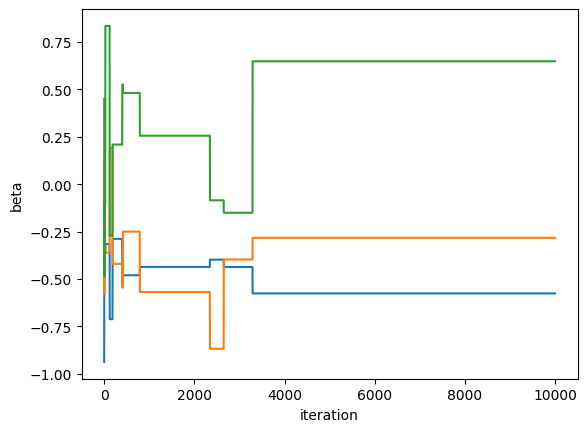

In [ ]:
# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta')

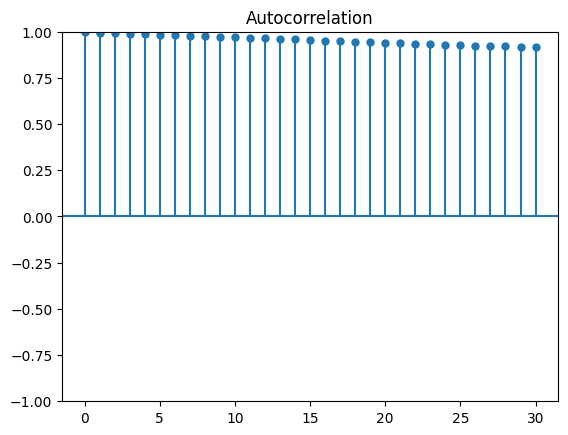

<Figure size 640x480 with 0 Axes>

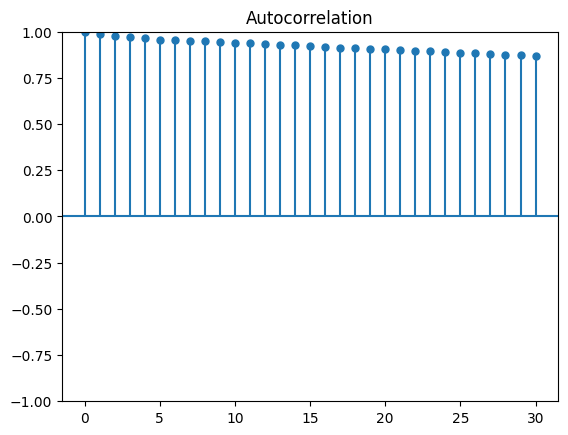

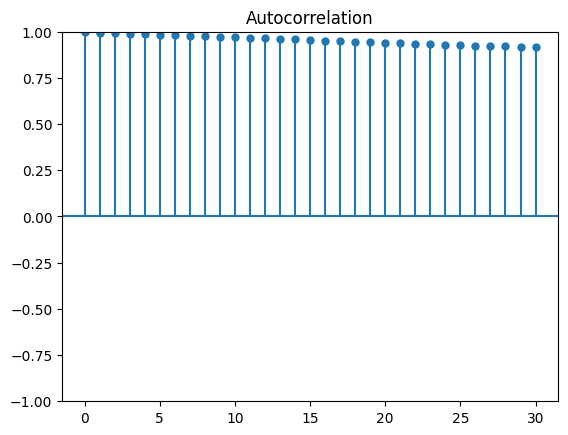

In [ ]:
# auto-correlation function
from statsmodels.graphics.tsaplots import plot_acf

plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)

2. Implement a random walk Metropolis–Hastings algorithm with the proposal transition den- sity q(β′|β) = N(β′;β,σ2Id+1). Initialize the Markov chain using a sample from the prior distribution and run the algorithm for N = 10, 000 iterations. Experiment with the choice of σ ∈ {0.002, 0.02, 0.2}. Using the acceptance rates that you observe and diagnostic plots, explain which of the three choice of σ is the best.

- As we compute for various sigma, we can define a function. 

In [ ]:
def random_walk_metropolis_hastings(sigma, N,D):

    beta = sample_prior()
    store_beta = np.zeros((N, D))

    num_accept = 0 

    for n in tqdm(range(N)):
        
        # 1) sample proposed state
        proposed_state = beta + sigma * np.random.randn(D)
    
        # 2) evaluate posterior densities
        logdensity_proposed = logdensity(proposed_state)
        logdensity_current = logdensity(beta)
    
        # 4) log-acceptance prob
        logacceptprob = float(logdensity_proposed - logdensity_current)
    
        # 5) accept or reject
        uniform = np.random.rand(1) # sample a uniform on [0,1]
        if np.log(uniform) < logacceptprob:
            beta = proposed_state.copy() # accepting 
            num_accept += 1
    
        # 6) store states 
        store_beta[n,:] = beta

    return store_beta, num_accept

### Sigma = 0.002

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:10<00:00, 141.14it/s]


acceptance rate 0.9234


Text(0, 0.5, 'sample average')

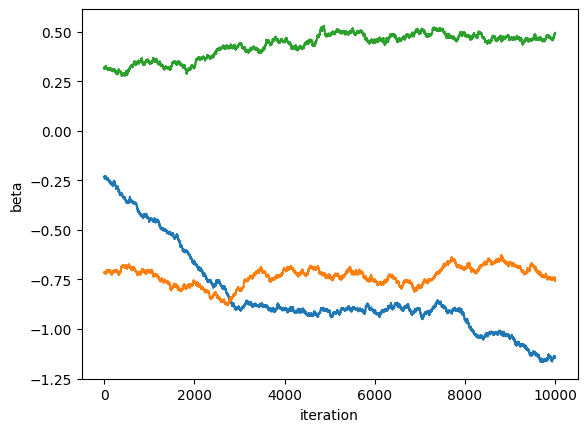

<Figure size 640x480 with 0 Axes>

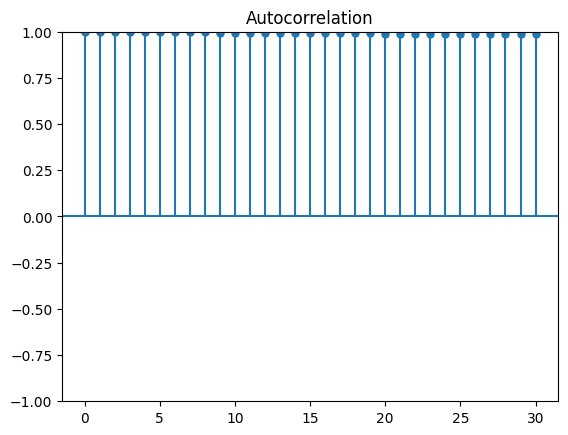

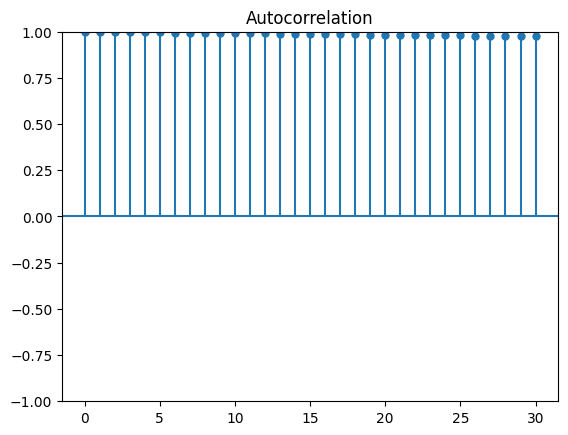

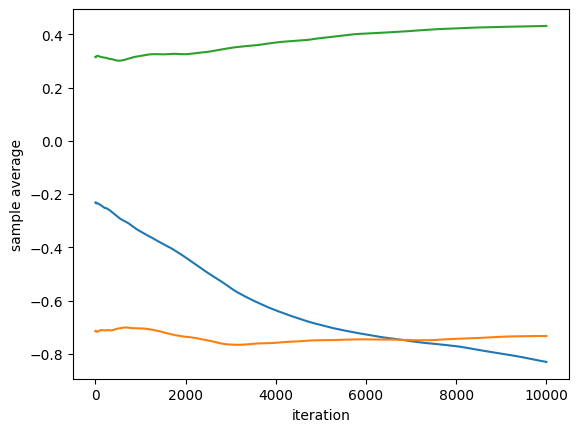

In [ ]:
store_beta, num_accept = random_walk_metropolis_hastings(sigma =0.002, 
                                                                       N = N, 
                                                                        D = D )

# acceptance rate
print("acceptance rate", num_accept / N )

# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta')

plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)

plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2]) / iteration)
plt.xlabel('iteration')
plt.ylabel('sample average')

### Sigma = 0.02

In [ ]:
store_beta, num_accept = random_walk_metropolis_hastings(sigma =0.02, 
                                                                       N = N, 
                                                                        D = D )

# acceptance rate
print("acceptance rate", num_accept / N )

# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta')

plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)

plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2]) / iteration)
plt.xlabel('iteration')
plt.ylabel('sample average')

 27%|██▋       | 2677/10000 [00:25<01:09, 105.90it/s]


KeyboardInterrupt: 

### Sigma = 0.2

100%|██████████| 10000/10000 [00:02<00:00, 4328.78it/s]


acceptance rate 0.6126


Text(0, 0.5, 'sample average')

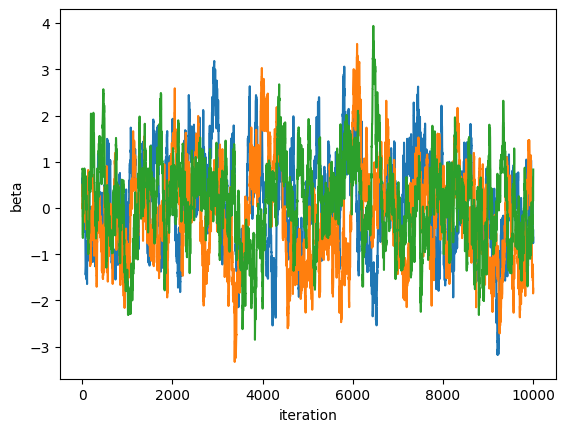

<Figure size 640x480 with 0 Axes>

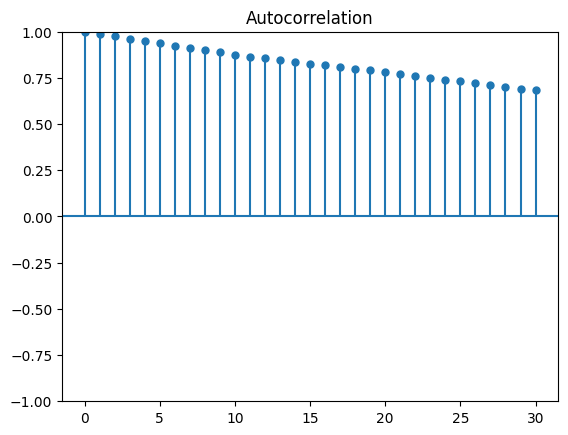

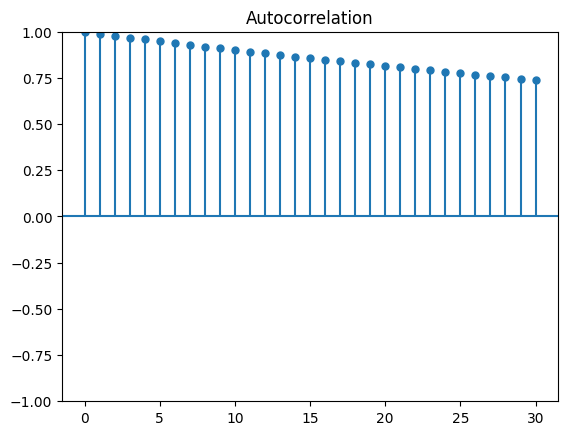

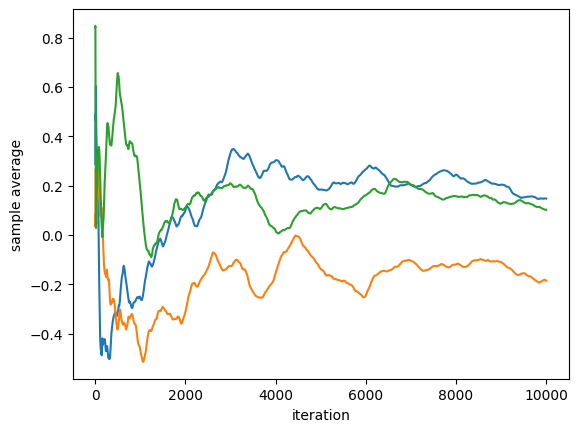

In [ ]:
store_beta, num_accept = random_walk_metropolis_hastings(sigma =0.2, 
                                                                       N = N, 
                                                                        D = D )

# acceptance rate
print("acceptance rate", num_accept / N )

# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta')

plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)

plt.figure()
plt.plot(iteration, np.cumsum(store_beta[:,0]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,1]) / iteration)
plt.plot(iteration, np.cumsum(store_beta[:,2]) / iteration)
plt.xlabel('iteration')
plt.ylabel('sample average')

3. Implement a Metropolis-adjusted Langevin algorithm which is defined by the proposal tran- sition density

Initialize the Markov chain using a sample from the prior distribution and run the algorithm for N = 10, 000 iterations. Experiment with the choice of σ between 0.04 to 0.12. Using the acceptance rates that you observe and diagnostic plots, what is a good choice of σ?


In [ ]:
# Q3: Metropolis-adjusted Langevin algorithm

# Define the log-density function (posterior log-probability)
def logdensity(beta):
    # Replace this with the actual log-density function
    return -0.5 * jnp.dot(beta, beta)  # Example: standard normal log-density

# Compute the gradient of the log-density function
logdensity_grad = grad(logdensity)

# initialize the Markov chain
beta = sample_prior()
# sigma = 0.002
sigma = 0.02
# sigma = 0.2

N = 10000
store_beta = np.zeros((N, D))
num_accept = 0 


for n in range(N):

    # 1) Compute the gradient at the current state
    grad_logdensity = logdensity_grad(beta)

    # 2) sample proposed state
    proposed_state = beta + (sigma**2 / 2) * grad_logdensity + sigma * np.random.randn(D)

    # 3) evaluate posterior densities
    logdensity_proposed = logdensity(proposed_state)
    logdensity_current = logdensity(beta)

    # 4) log-acceptance prob
    logacceptprob = float(logdensity_proposed - logdensity_current)

    # 5) accept or reject
    uniform = np.random.rand(1) # sample a uniform on [0,1]
    if np.log(uniform) < logacceptprob:
        beta = proposed_state.copy() # accepting 
        num_accept += 1

    # 6) store states 
    store_beta[n,:] = beta

In [ ]:
# acceptance rate
num_accept / N 

0.9697

Text(0, 0.5, 'beta')

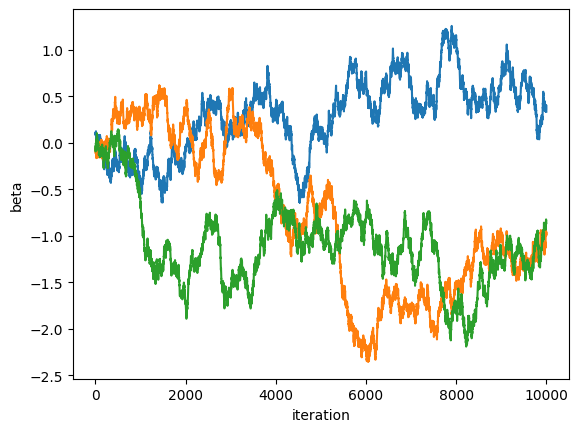

In [ ]:
# trace plot
iteration = np.arange(1, N+1)
plt.figure()
plt.plot(iteration, store_beta[:,0])
plt.plot(iteration, store_beta[:,1])
plt.plot(iteration, store_beta[:,2])
plt.xlabel('iteration')
plt.ylabel('beta')

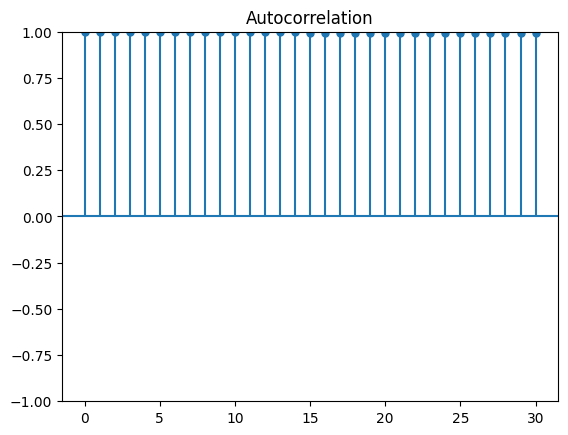

<Figure size 640x480 with 0 Axes>

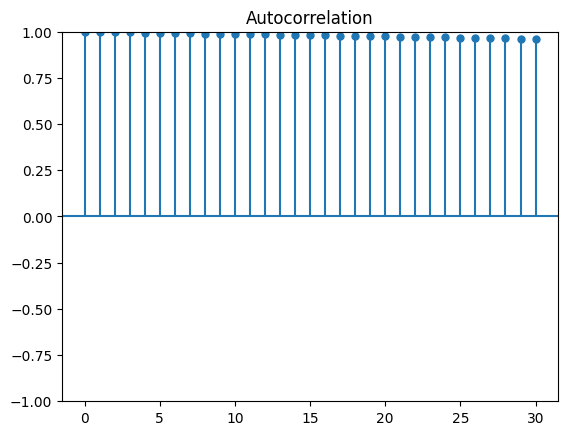

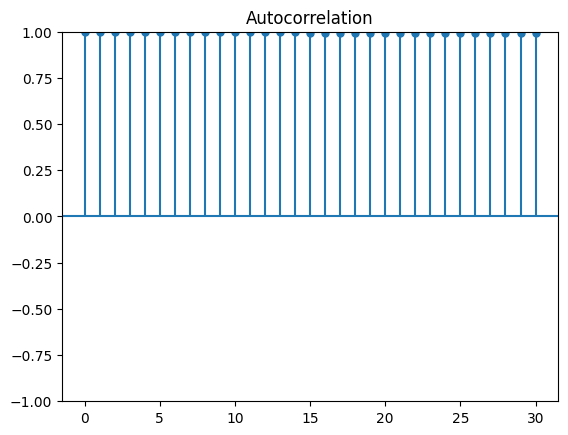

In [ ]:
plt.figure()
plot_acf(store_beta[:,0], lags = 30, alpha = None)
plot_acf(store_beta[:,1], lags = 30, alpha = None)

4. Implement a Hamiltonian Monte Carlo algorithm by using the hamiltonian_dynamics func- tion in the Python script hmc.py (in the Project1 folder on Moodle) to simulate Hamiltonian dynamics. Initialize the Markov chain using a sample from the prior distribution and run the algorithm for N = 10, 000 iterations. Experiment with the choice of stepsize between 0.01 to 0.1. Using the acceptance rates that you observe, what is a good choice of stepsize? Using diagnostic plots, compare the performance of the algorithm with 5 or 10 number of steps. To do model predictions in the following, perform a final run of the Markov chain, with the best stepsize that you found and 10 number of steps, for 11, 000 iterations and discard the first 1000 iterations as burn-in.

## TODO

# Q4. Model predictions

1. The Bayesian approach to prediction is based on the predictive probability where X = (X1, . . . , Xd) denotes the features of an individual in the testing dataset. Given Markov chain Monte Carlo samples β(t),t = 1,...,N, explain why it is sensible to approxi- mate the predictive probability by

## TODO

2. Using the Hamiltonian Monte Carlo samples from your final run in Question 3.4, approximate the predictive probabilities for all n = 200 individuals in the testing dataset stored in the NumPy array xtest.

## TODO

3. Using these predictive probabilities, implement the prediction rule

## TODO

4. Using the actual classification stored in the NumPy vector ytest, compute the misclassifi- cation rate.

5. In this application, it is worse to classify an individual as having good credit risk when they are bad, than it is to classify an individual as having bad credit risk when they are good. These differences are captured using the following cost function

6. We will compare Bayesian predictions with a maximum likelihood approach that would
predict using the rule

7. Using the actual classification stored in the NumPy vector ytest, compute the misclassifi- cation rate and average cost under the maximum likelihood approach.

8. Compare the prediction accuracy obtained using the Bayesian and maximum likelihood ap- proaches, and explain your findings.